In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    cohen_kappa_score,
    classification_report,
    f1_score,
    make_scorer,
    recall_score,
    precision_score,
    auc
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


import warnings
warnings.filterwarnings("ignore")

In [105]:
#dataset
data = pd.read_csv("/Users/anhuynh/Downloads/cannabis_full.csv")


In [106]:
# Filter data for Sativa and Indica only
filtered_data = data[data['Type'].isin(['sativa', 'indica'])]

# Drop irrelevant columns
filtered_data = filtered_data.drop(columns=['Effects', 'Flavor', 'Strain'])

# Drop rows with missing values
filtered_data = filtered_data.dropna()


# Spilt data
X = filtered_data.drop(columns=['Type'])  
y = filtered_data['Type']  

filtered_data = filtered_data.dropna(subset=X.columns)




### Part One: Binary Classification


I choose F1 scores because I noticed that the two strains are a little bit unbalanced. F1 Score gives a more realistic assessment of the model's performance using precision and recall, especially when the classes are imbalanced. But I also included accuary in my results as another intuition check of the metrics. 

In [87]:
#create a model evaulation function - Chatgpt was used in asssiting of this function writing
def evaluate_model(X, y, model_type="lda", param_grid=None, cv_folds=5, random_state=42):
    """
    Evaluate and find the best model for predicting the Type variable.

    Parameters:
    - X (DataFrame): Features.
    - y (Series): Target variable.
    - model_type (str): Model to evaluate. Options: "lda", "qda", "svc", "svm".
    - param_grid (dict): Hyperparameter grid for tuning. Default: None.
    - cv_folds (int): Number of cross-validation folds. Default: 5.
    - random_state (int): Random state for reproducibility. Default: 42.

    Returns:
    - best_model: Fitted model with the best parameters.
    - cv_score: Cross-validated metric for the best model.
    - conf_matrix: Confusion matrix for test data.
    """

    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Convert to numeric labels (0 and 1)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_state)
    
    # Initialize the model
    if model_type == "lda":
        model = LinearDiscriminantAnalysis()
        if not param_grid:
            param_grid = {}  # No hyperparameters for LDA
    elif model_type == "qda":
        model = QuadraticDiscriminantAnalysis()
        if not param_grid:
            param_grid = {}  # No hyperparameters for QDA
    elif model_type == "svc":
        model = SVC()
        if not param_grid:
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    elif model_type == "svm":
        model = SVC(kernel='poly')
        if not param_grid:
            param_grid = {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
    else:
        raise ValueError("Invalid model_type. Choose from 'lda', 'qda', 'svc', or 'svm'.")

    # Cross-validation and hyperparameter tuning
    scorer = make_scorer(f1_score, average='weighted')  # Balanced metric
    grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=cv_folds)
    grid_search.fit(X_train, y_train)

    # Best model and cross-validated metric
    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring=scorer)
    cv_score = np.mean(cv_scores)

    # Final model evaluation on the test set
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    class_labels = le.classes_  # Get class labels from the LabelEncoder
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Model: {model_type.upper()}")
    print(f"Cross-Validated F1 Score: {cv_score:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    
    return best_model, cv_score, conf_matrix



Q1: LDA


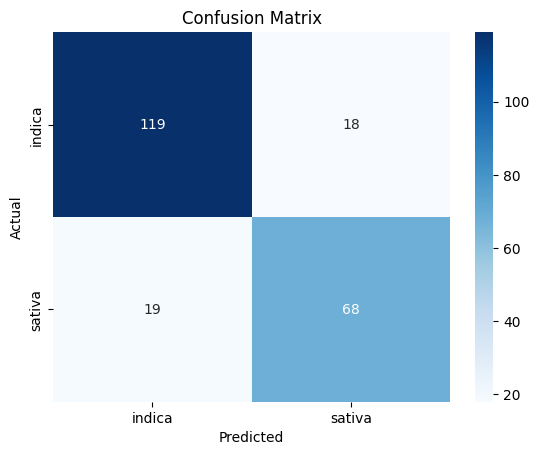

Model: LDA
Cross-Validated F1 Score: 0.837
Confusion Matrix:
[[119  18]
 [ 19  68]]
Test Accuracy: 0.835


In [88]:
lda_model, lda_cv_score, lda_conf_matrix = evaluate_model(X, y, model_type="lda")


Q2: QDA



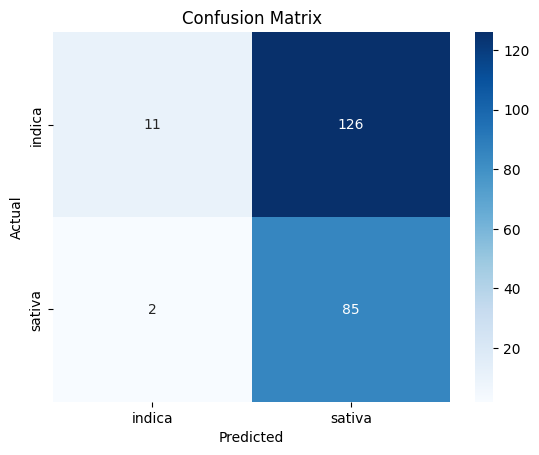

Model: QDA
Cross-Validated F1 Score: 0.415
Confusion Matrix:
[[ 11 126]
 [  2  85]]
Test Accuracy: 0.429


In [89]:
qda_model, qda_cv_score, qda_conf_matrix = evaluate_model(X, y, model_type="qda")


Q3: SVC



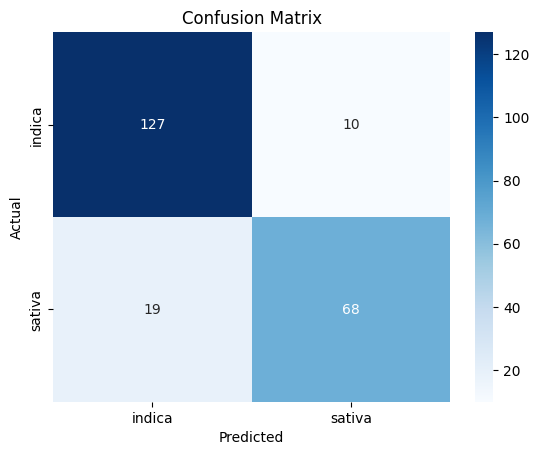

Model: SVC
Cross-Validated F1 Score: 0.846
Confusion Matrix:
[[127  10]
 [ 19  68]]
Test Accuracy: 0.871


In [90]:
svc_model, svc_cv_score, svc_conf_matrix = evaluate_model(X, y, model_type="svc")


Q4: SVM


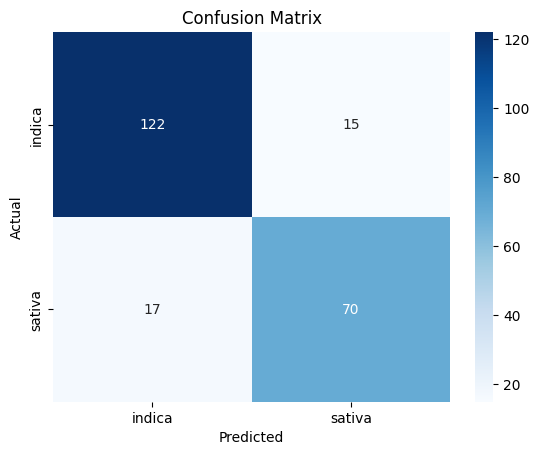

Model: SVM
Cross-Validated F1 Score: 0.853
Confusion Matrix:
[[122  15]
 [ 17  70]]
Test Accuracy: 0.857


In [91]:
svm_model, svm_cv_score, svm_conf_matrix = evaluate_model(X, y, model_type="svm")


### Part Two: Natural Multiclass


In [107]:
#date cleaning
# Filter data for Sativa and Indica only
full_data = data[data['Type'].isin(['sativa', 'indica', 'hybrid'])]


In [104]:
# Drop rows with missing values
full_data = full_data.dropna()

# Drop rows with NaN in feature columns
full_data = full_data.dropna(subset=X.columns)

#Spilting data 
X = full_data.drop(columns=['Type'])  # Exclude only the target
y = full_data['Type']  # Target



Q1

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'tree__max_depth': 5, 'tree__max_features': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 5}


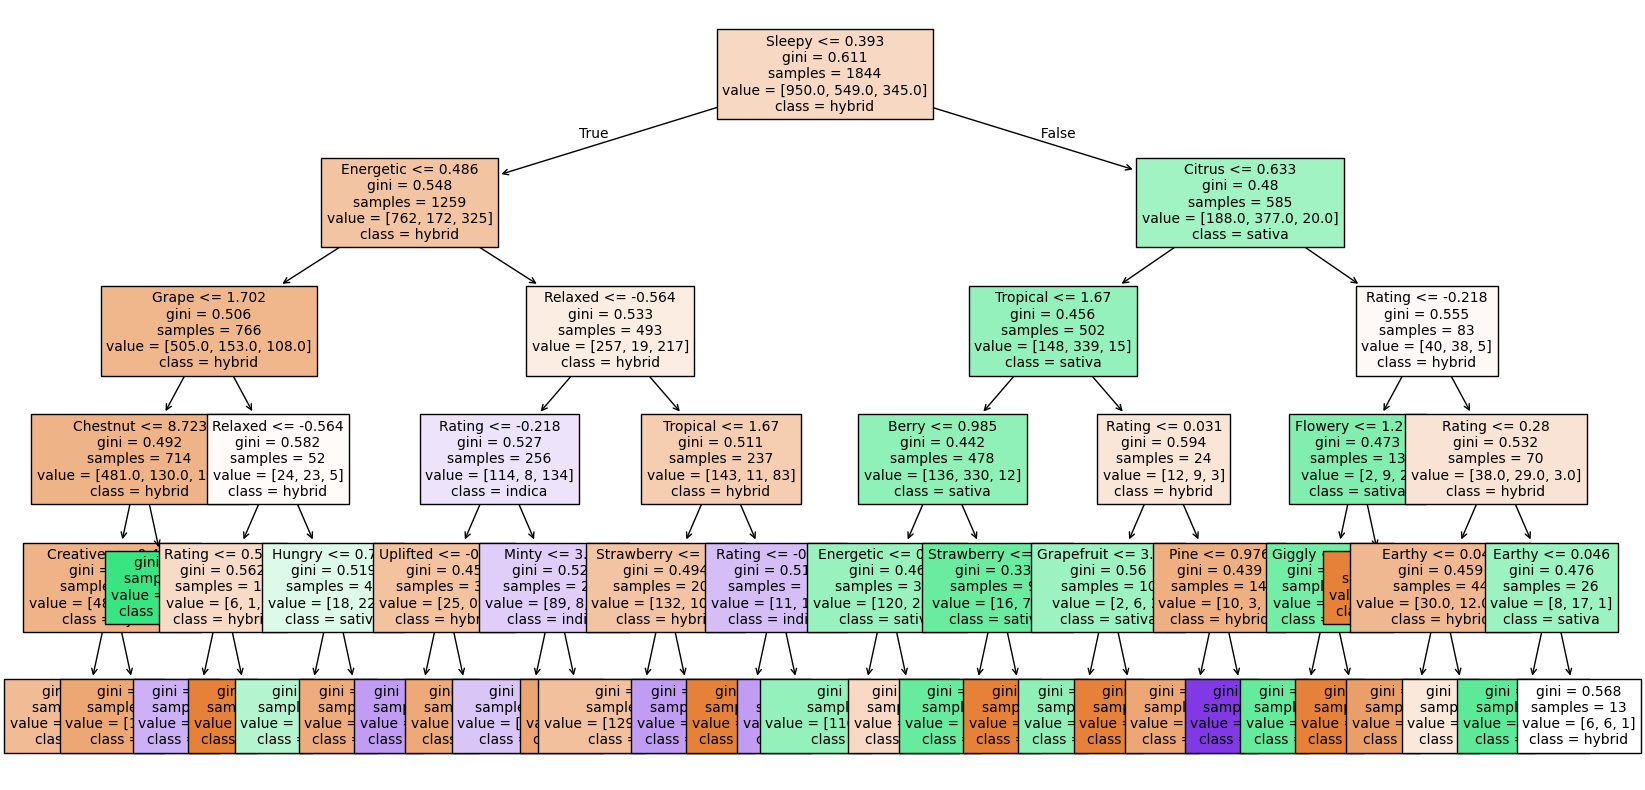

Decision Tree F1 Score: 0.588
Decision Tree Accuracy: 0.594
Confusion Matrix:
 [[163  48  26]
 [ 56  79   3]
 [ 48   6  32]]


In [94]:
# Split the dataset into features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X.select_dtypes(include=['float64', 'int']).columns),
        ("cat", OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough'
)

# Pipeline and hyperparameters
pipeline_tree = Pipeline([("preprocessing", preprocessor), ("tree", DecisionTreeClassifier(random_state=42))])
params_tree = {
    'tree__max_depth': [3, 5, 10],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(pipeline_tree, params_tree, cv=5, scoring='f1_weighted', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_tree = grid_search.best_estimator_.named_steps['tree']
print("Best Parameters:", grid_search.best_params_)

# Visualize the best tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=y.unique(), fontsize=10)
plt.show()

# Predictions and evaluation
y_pred = grid_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Decision Tree F1 Score: {f1:.3f}")
print(f"Decision Tree Accuracy: {accuracy:.3f}")
print("Confusion Matrix:\n", conf_matrix)


As shown by the confusion matrix, there is the class imbalance for Hybrid. This makes it harder to correctly classify Indica and Sativa. The F1 score of 0.588 and accuracy  of 0.59 also suggest that the model is somewhat balanced but still struggles with precision and recall, perhaps due to the imbalance. Sleepy, Energetic, and Citrus has a strong impact on model. 

Q2

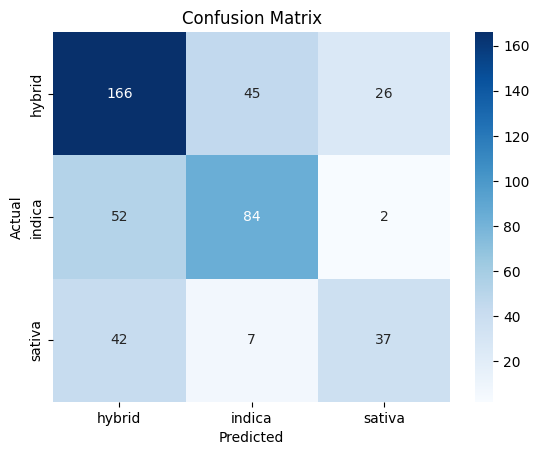

Model: LDA
Cross-Validated F1 Score: 0.617
Confusion Matrix:
[[166  45  26]
 [ 52  84   2]
 [ 42   7  37]]
Test Accuracy: 0.623


In [95]:
lda_model, lda_cv_score, lda_conf_matrix = evaluate_model(X, y, model_type="lda")


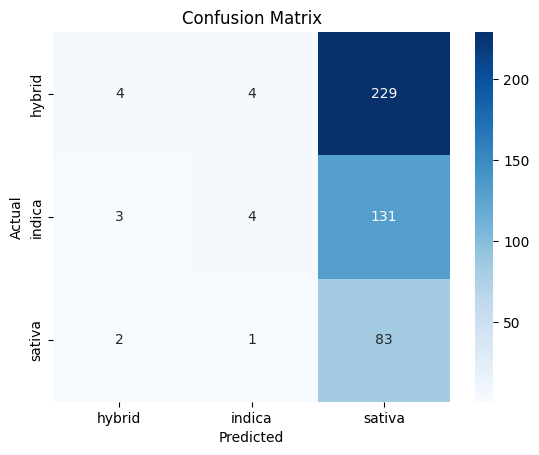

Model: QDA
Cross-Validated F1 Score: 0.109
Confusion Matrix:
[[  4   4 229]
 [  3   4 131]
 [  2   1  83]]
Test Accuracy: 0.197


In [96]:
qda_model, qda_cv_score, qda_conf_matrix = evaluate_model(X, y, model_type="qda")


Best KNN Parameters: {'n_neighbors': 19}
KNN Classification Report:
               precision    recall  f1-score   support

      hybrid       0.62      0.81      0.70       237
      indica       0.65      0.59      0.62       138
      sativa       0.70      0.22      0.34        86

    accuracy                           0.63       461
   macro avg       0.66      0.54      0.55       461
weighted avg       0.64      0.63      0.61       461

KNN Confusion Matrix:
 [[191  39   7]
 [ 56  81   1]
 [ 62   5  19]]
KNN Accuracy: 0.631


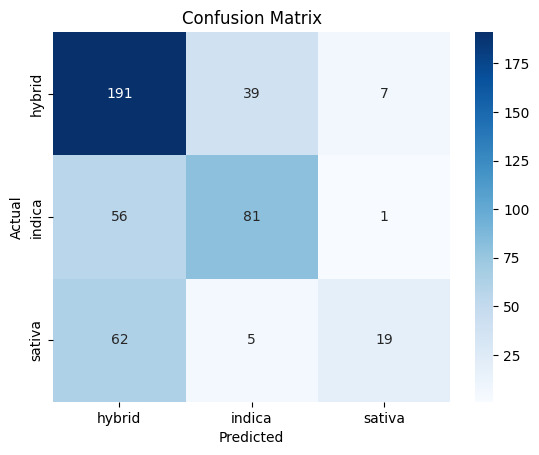

In [97]:


# Hyperparameter tuning for KNN
knn_params = {'n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Get the best KNN model
knn_best = knn_grid.best_estimator_

# Train the best model on the training data
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

# Print the best parameters
print("Best KNN Parameters:", knn_grid.best_params_)

# Print the classification report
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Print the confusion matrix
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

# Print accuracy
print(f'KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)  # Define confusion matrix
class_labels = np.unique(y_train)  # Get class labels from the training data

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Q3

My part one metrics were better. It is due to the addition of the hybrid strain being added. Hybrid are a mix of characteristics of the two other strains Sativa and Indica so its hard for the model to indifferenate each of the strains. Thus, making the metrics in part 2 worse than the one in part 1. According to the confusion matrices, the categories that were most likely to get mixed up were predicted hybrid vs actual sativa in the KNN model, predicted sativa vs actual hybrid in QDA model, and predicted hybrid vs actual indica in LDA model. The common trend is the hybrid strain as the false predicted or inaccurate actual category due to the ambiguous nature of the hybrid strain being a combination of both of the other strains.  

### Part Three: Multiclass from Binary


In [98]:
#Defining the types in a dataframe
y_ind = (y == 'indica').astype(int)
y_sat = (y == 'sativa').astype(int)
y_hyb = (y == 'hybrid').astype(int) 

Q1

In [99]:
ct = ColumnTransformer(
    [("num", StandardScaler(), ['Rating'])],
    remainder="passthrough"
)

pipeline_log = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(solver='lbfgs', max_iter=1000))]
)

params_log = {
    'log__C': [0.01, 0.1, 1, 10, 100]
}

pipeline_svc = Pipeline(
     [("preprocessing", ct),
      ("svc", SVC(max_iter=1000))]
)

params_svc = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__kernel": ['linear', 'rbf', 'sigmoid'],
    "svc__gamma": ['scale', 'auto']
}


Logistic Regression: indica vs Not indica
f1 for indica vs Not indica: 0.8062034067935953


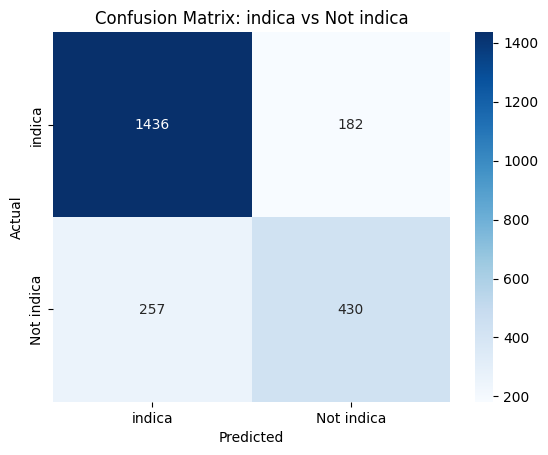


SVC: indica vs Not indica
f1 for indica vs Not indica: 0.7893275804921083


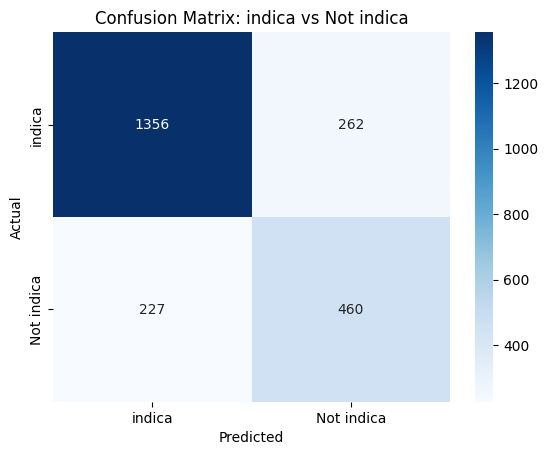


Logistic Regression: sativa vs Not sativa
f1 for sativa vs Not sativa: 0.8151062307636624


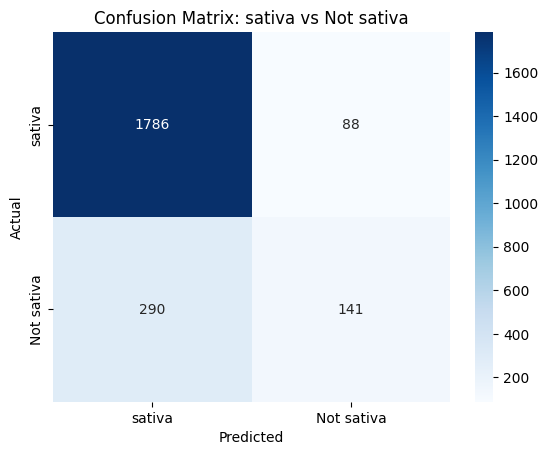


SVC: sativa vs Not sativa
f1 for sativa vs Not sativa: 0.729165089988731


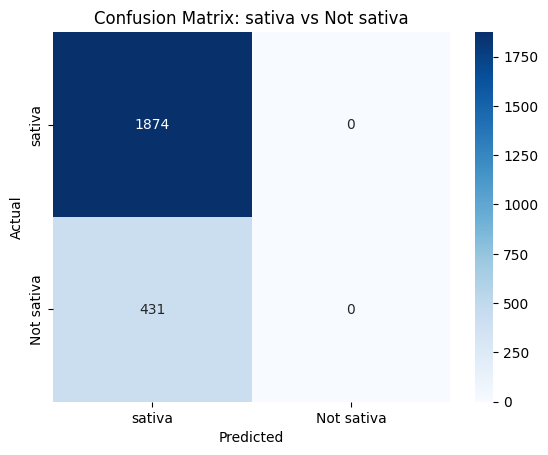


Logistic Regression: hybrid vs Not hybrid
f1 for hybrid vs Not hybrid: 0.6437920105810916


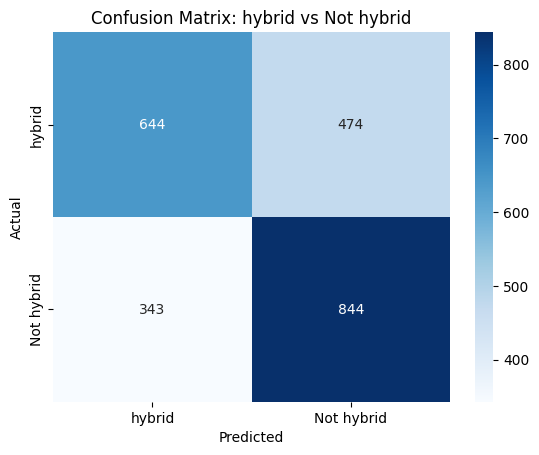


SVC: hybrid vs Not hybrid
f1 for hybrid vs Not hybrid: 0.6208209217842674


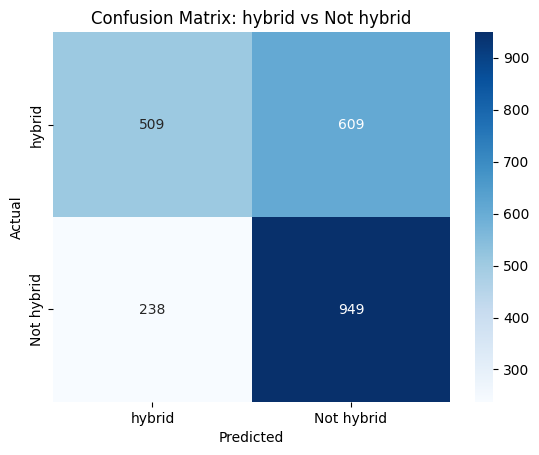

In [100]:
# Function to create and evaluate OvR models for each class vs not class
def create_ovr_model(pipeline, base_model, X, y, class1):
    # Create binary target: class1 vs. not class1
    y_filtered = y == class1
    X_filtered = X[(y == class1) | (y != class1)]
    
    # Initialize OneVsRestClassifier
    ovr_model = OneVsRestClassifier(base_model)
    
    # Fit the model
    ovr_model.fit(X_filtered, y_filtered)
    
    # Make predictions
    y_pred = ovr_model.predict(X_filtered)
    
    # Calculate f1 score
    f1 = f1_score(y_filtered, y_pred, average='weighted')
    print(f"f1 for {class1} vs Not {class1}: {f1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_filtered, y_pred)
    class_labels = [class1, 'Not ' + class1]
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {class1} vs Not {class1}')
    plt.show()

# Define the classes
classes = ['indica', 'sativa', 'hybrid']

# Create the OvR models and report metrics for each class vs not class
for class1 in classes:
    # For Logistic Regression (with OvR)
    print(f"\nLogistic Regression: {class1} vs Not {class1}")
    create_ovr_model(pipeline_log, LogisticRegression(solver='lbfgs', max_iter=1000), X, y, class1)
    
    # For SVC (with OvR)
    print(f"\nSVC: {class1} vs Not {class1}")
    create_ovr_model(pipeline_svc, SVC(max_iter=1000), X, y, class1)

Q2

Best Model:
Logistic Regression: sativa vs Not sativa

F1 for sativa vs Not sativa: 0.8151062307636624

Worst Model: 
SVC: hybrid vs Not hybrid

F1 for hybrid vs Not hybrid: 0.6208209217842674

It does make sense because Hybrid is more ambiguous than the other two strains, thus it would be harder to predict. 


Q3


Logistic Regression: indica vs sativa
f1 for indica vs sativa: 0.8709680806770286


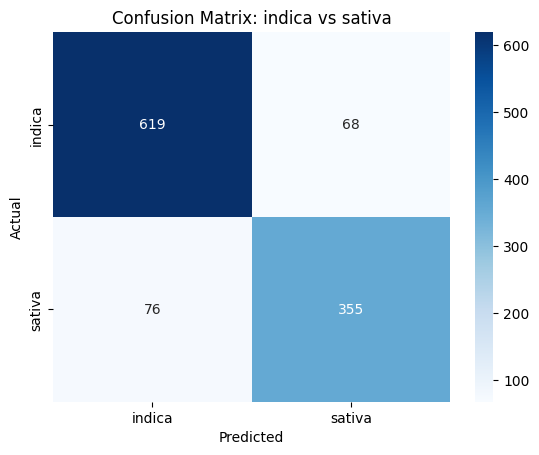


SVC: indica vs sativa
f1 for indica vs sativa: 0.8739070996232604


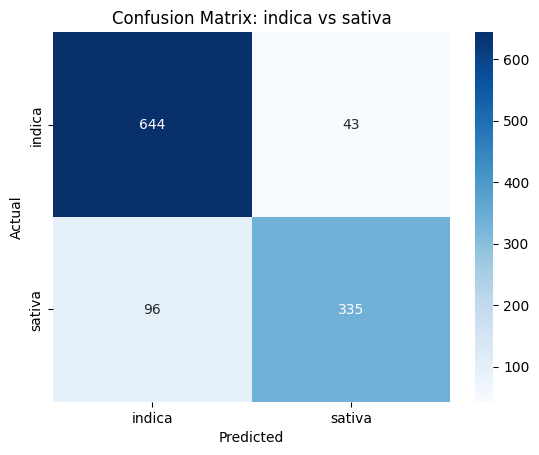


Logistic Regression: indica vs hybrid
f1 for indica vs hybrid: 0.7711391486664831


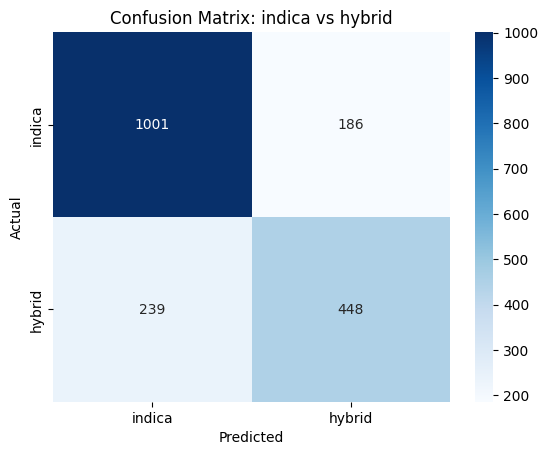


SVC: indica vs hybrid
f1 for indica vs hybrid: 0.7543344893174879


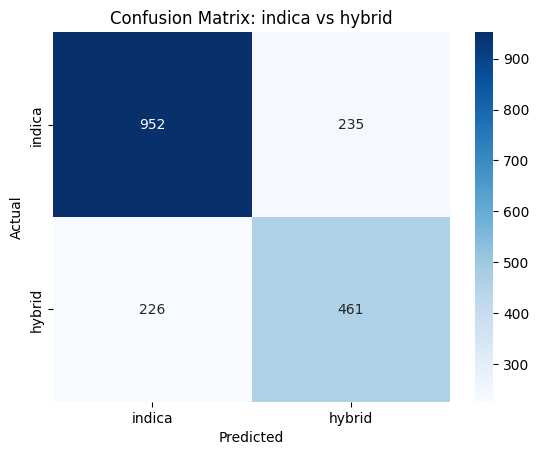


Logistic Regression: sativa vs hybrid
f1 for sativa vs hybrid: 0.7442339632847179


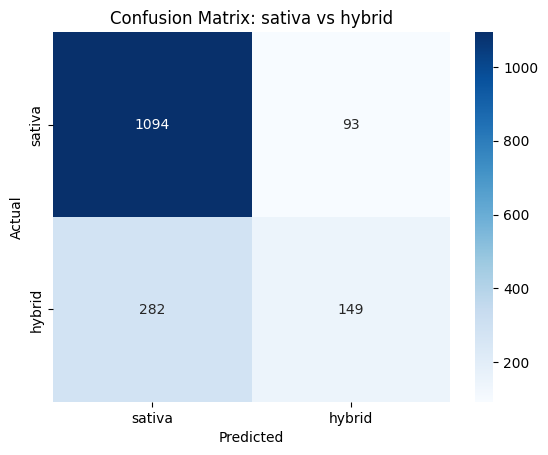


SVC: sativa vs hybrid
f1 for sativa vs hybrid: 0.6345408068782417


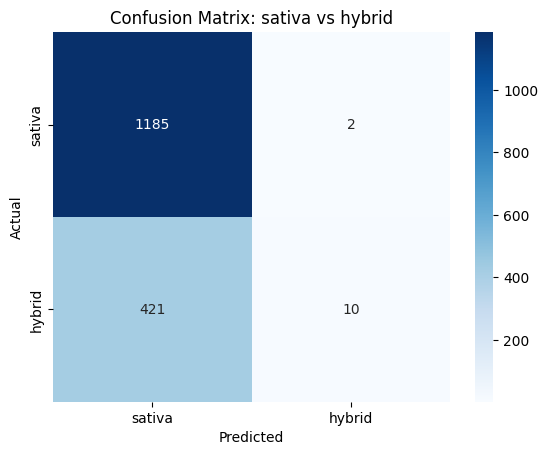

In [101]:
# Function to create and evaluate OvO models for each combination of classes
def create_ovo_model(pipeline, base_model, X, y, class1, class2):
    # Filter the data for the current pair of classes (e.g., Indica vs Sativa)
    y_filtered = y[(y == class1) | (y == class2)]
    X_filtered = X[(y == class1) | (y == class2)]
    
    # Initialize OneVsOneClassifier
    ovo_model = OneVsOneClassifier(base_model)
    
    # Fit the model
    ovo_model.fit(X_filtered, y_filtered)
    
    # Make predictions
    y_pred = ovo_model.predict(X_filtered)
    
    # Calculate f1 score
    f1 = f1_score(y_filtered, y_pred, average='weighted')
    print(f"f1 for {class1} vs {class2}: {f1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_filtered, y_pred)
    class_labels = [class1, class2]
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {class1} vs {class2}')
    plt.show()

# Define the classes
classes = ['indica', 'sativa', 'hybrid']

# Create the OvO models and report metrics for each combination
for i in range(len(classes)):
    for j in range(i + 1, len(classes)):
        class1, class2 = classes[i], classes[j]

        # For Logistic Regression (with OvO)
        print(f"\nLogistic Regression: {class1} vs {class2}")
        create_ovo_model(pipeline_log, LogisticRegression(solver='lbfgs', max_iter=1000), X, y, class1, class2)
        
        # For SVC (with OvO)
        print(f"\nSVC: {class1} vs {class2}")
        create_ovo_model(pipeline_svc, SVC(max_iter=1000), X, y, class1, class2)



Q4

Best Model:
SVC: indica vs sativa

F1 for indica vs sativa: 0.8739070996232604

Worst Model: 
SVC: sativa vs hybrid

F1 for sativa vs hybrid: 0.6345408068782417

As stated like above, it does make sense because Hybrid is more ambiguous than the other two strains, thus it would be harder to predict when compared to other strains like it. 

Q5

In Logistic Regression, the default multiclass strategy is One-vs-Rest (OvR).
For SVC, the default multiclass strategy is also One-vs-Rest (OvR).